In [453]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import time, os, sys
from tqdm import tqdm

from matplotlib import pyplot as plt
from utils.basic_utils import *
from utils.pricing import get_symbol_pricing, roll_vol, max_draw_pull, sign_compare, load_px_close, get_return_intervals

### Context data

In [462]:
# context data
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

In [463]:
# get latest pricing file from inferece server
# px_close_ds = context['px_close']
# tmp_path = context['tmp_path']
# os.makedirs(tmp_path, exist_ok=True)
# !scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [464]:
# Quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

equity_symbols = config['companies']
quotes = load_csvs('quote_consol', [tgt_date])
quotes = quotes.loc[quotes.symbol.isin(equity_symbols)]
quotes.set_index('symbol', drop=False, inplace=True)
profile = load_csvs('summary_detail', ['assetProfile'])
profile = profile.loc[profile.symbol.isin(equity_symbols)]
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-17
Loading file quote/csv/2019-05-17
Loading file summary-categories/assetProfile


In [465]:
# load stored pricing
px_close = load_px_close('../tmp/', 'universe-px-ds', True).drop_duplicates()
print('px_close.info()', px_close.info())
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
clean_co_px = px_close.dropna(subset=[bench])[tickers].fillna(method='ffill')
cut_range = get_return_intervals(clean_co_px, 120, tresholds=[0.25, 0.75])
print(f'Return intervals {np.round(cut_range, 3)}')

<class 'pandas.core.frame.DataFrame'>
Index: 4674 entries, 2004-05-16 to 2019-05-17
Columns: 1291 entries, 0700.HK to KRW=X
dtypes: float32(1291)
memory usage: 23.1+ MB
px_close.info() None
Return intervals [  -inf -0.175 -0.106  0.139  0.251    inf]


In [466]:
# Training/inference subset
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

from utils.fundamental import best_performers
from utils.pricing import get_universe_px_vol

# tickers = list(profile.loc[profile.sector.isin(tgt_sectors), 'symbol'])
tickers = list(best_performers(clean_co_px, tickers=tickers, years=10, quantile=0.75).index)

print(f'{len(tickers)} companies')

240 companies


#### Get universe OCHL+Vol dataset

In [467]:
def load_px_vol_ds(path, fname, load_ds=True):
    """ 
    Refresh price and volume daily, 
    used by most models with technical stats without refreshing 
    """
    if os.path.isfile(path + fname) and load_ds: 
        px_vol_ds = pd.read_hdf(path + fname, 'px_vol_df')
    else:
        # file does not exist, refreshes full dataset
        px_vol_ds = get_universe_px_vol(UNIVERSE)
        num_cols = numeric_cols(px_vol_ds)
        px_vol_ds.loc[:, num_cols] = px_vol_ds[num_cols].astype(np.float32)
        os.makedirs(path, exist_ok=True)
        px_vol_ds.to_hdf(path + fname, 'px_vol_df')
#     px_vol_ds.index = px_close.index.date
    return px_vol_ds

In [468]:
%%time
px_vol_df = load_px_vol_ds('../tmp/', 'universe-px-vol-ds.h5', True)

CPU times: user 20.2 ms, sys: 80.3 ms, total: 101 ms
Wall time: 103 ms


In [469]:
compare = 'companies'
px_close[config[compare]].tail()

,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL,...,YELP,YUM,YY,ZBH,ZBRA,ZEN,ZION,ZTO,ZTS,ZUO
2019-05-13,NaN,NaN,NaN,10570.0,73.839996,32.139999,54.189999,46.560001,155.369995,185.720001,...,31.559999,100.410004,66.410004,118.660004,181.009995,83.889999,46.029999,18.260000,101.349998,21.129999
2019-05-14,370.600006,10.12,58.299999,9995.0,76.010002,32.340000,54.459999,46.570000,155.750000,188.660004,...,32.299999,100.680000,67.269997,118.750000,186.720001,85.489998,46.439999,18.490000,101.250000,21.809999
2019-05-15,374.000000,10.48,60.200001,10315.0,67.639999,32.160000,54.240002,46.639999,155.830002,190.919998,...,32.930000,100.360001,68.089996,118.550003,185.179993,86.669998,45.130001,18.820000,101.839996,22.240000
2019-05-16,365.600006,10.30,60.000000,10075.0,69.300003,32.320000,55.080002,46.310001,157.279999,190.080002,...,32.849998,100.870003,69.050003,118.080002,190.020004,89.000000,45.570000,19.540001,102.930000,22.559999
2019-05-17,355.799988,10.16,61.849998,10300.0,69.110001,31.740000,54.419998,45.910000,157.970001,189.000000,...,32.410000,101.300003,67.500000,116.419998,179.119995,87.959999,45.099998,17.930000,101.970001,22.330000


In [470]:
px_vol_df['close'][config[compare]].tail()

symbol,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL,...,YELP,YUM,YY,ZBH,ZBRA,ZEN,ZION,ZTO,ZTS,ZUO
storeDate,,,,,,,,,,,,,,,,,,,,,
2019-05-13,NaN,NaN,NaN,10570.0,73.839996,32.139999,54.189999,46.560001,155.369995,185.720001,...,31.559999,100.410004,66.410004,118.660004,181.009995,83.889999,46.029999,18.260000,101.349998,21.129999
2019-05-14,370.600006,10.12,58.299999,9995.0,76.010002,32.340000,54.459999,46.570000,155.750000,188.660004,...,32.299999,100.680000,67.269997,118.750000,186.720001,85.489998,46.439999,18.490000,101.250000,21.809999
2019-05-15,374.000000,10.48,60.200001,10315.0,67.639999,32.160000,54.240002,46.639999,155.830002,190.919998,...,32.930000,100.360001,68.089996,118.550003,185.179993,86.669998,45.130001,18.820000,101.839996,22.240000
2019-05-16,365.600006,10.30,60.000000,10075.0,69.300003,32.320000,55.080002,46.310001,157.279999,190.080002,...,32.849998,100.870003,69.050003,118.080002,190.020004,89.000000,45.570000,19.540001,102.930000,22.559999
2019-05-17,355.799988,10.16,61.849998,10300.0,69.110001,31.740000,54.419998,45.910000,157.970001,189.000000,...,32.410000,101.300003,67.500000,116.419998,179.119995,87.959999,45.099998,17.930000,101.970001,22.330000


#### Create dataset

In [ ]:
def px_mom_feats(df, s, stds=1, invert=False, incl_px=False, rolls=[20,60,120], incl_name=True):
    ndf = pd.DataFrame()
    if invert: df = 1 / df
    #c,o,l,h = df['close'], df['open'], df['low'], df['high']
    c = df.dropna()
    c1ds, pctChg = c.shift(1), c.pct_change()
    if incl_px: ndf[s + 'Close'] = c
    ticker = s if incl_name else ''
    ndf[ticker+'PctChg'+str(stds)+'Stds'] = pctChg.apply(
        sign_compare, args=(pctChg.std() * stds,))
    ndf[ticker+'PctMA50'] = (c / c.rolling(50).mean())
    ndf[ticker+'PctMA200'] = (c / c.rolling(200).mean())
    ndf[ticker+'RollVol30'] = roll_vol(pctChg, 30)
    for p in rolls: ndf[ticker+'PctChg'+str(p)] = c.pct_change(periods=p)
    # ndf[ticker+'OpenGap20'] = ((o - c1ds) / c1ds).rolling(20).sum()
    # ndf[ticker+'HLDelta20'] = ((h - l) / c1ds).rolling(20).sum()
    ndf[ticker+'Pct52WkH'] = (c / c.rolling(252).max())
    ndf[ticker+'Pct52WkL'] = (c / c.rolling(252).min())
    if not incl_name: ndf['symbol'] = s
    return ndf

In [358]:
tickers = config['companies']
look_ahead = 120
symbol = 'AAPL'
sample_symbols = np.random.choice(tickers, 3)

In [485]:
def max_draw(xs):
    l_dd = np.argmax(np.maximum.accumulate(xs) - xs)
    h_dd = np.argmax(np.array(xs[:l_dd]))
    return xs[l_dd]/xs[h_dd]-1

def max_pull(xs):
    h_p = np.argmax(xs - np.minimum.accumulate(xs))
    l_p = np.argmin(np.array(xs[:h_p]))
    return xs[h_p]/xs[l_p]-1

def sign_compare(x, y):
    x_abs = np.abs(x)
    res = x_abs // y
    return (res * np.sign(x))

In [ ]:
### Generic Transforms

In [487]:
%%time
# price and volume base dataframes
# adjusted for SP500 trading days
# need to take into account instruments with inverted price (FX)
close_df = px_vol_df['close'].dropna(subset=[bench])
close_df = px_vol_df['close'].dropna(subset=[bench])
open_df = px_vol_df['open'].dropna(subset=[bench])
low_df = px_vol_df['low'].dropna(subset=[bench])
high_df = px_vol_df['high'].dropna(subset=[bench])
vol_df = px_vol_df['volume'].dropna(subset=[bench]) # relative to 10, 60 day average
dollar_value_df = close_df * vol_df # relative to 10, 60 day average

close_1d_shift_df = close_df.shift(1) # closed shifted 1 day for calcs
close_1d_chg_df = close_df - close_1d_shift_df # 1 day change

pct_chg_keys = [1, 20, 50, 200]
pct_chg_df_dict = {x: close_df.pct_change(x) for x in pct_chg_keys}

intra_day_chg_df = (high_df - low_df) / open_df # intra day range
open_gap_df = (open_df - close_1d_shift_df) / close_1d_shift_df # open gap

pct_50d_ma_df = close_df / close_df.rolling(50).mean() # % of 50 day moving average
pct_200d_ma_df = close_df / close_df.rolling(200).mean() # % of 200 day moving average
pct_52wh_df = close_df / close_df.rolling(252).max() # % of 52 week high
pct_52wl_df = close_df / close_df.rolling(252).min() # % of 52 week low

pct_vol_10da_df = vol_df / vol_df.rolling(10).mean() # vol as a pct of 10 day average
pct_vol_50da_df = vol_df / vol_df.rolling(50).mean() # vol as a pct of 60 day average
pct_dv_10da_df = dollar_value_df / dollar_value_df.rolling(10).mean() # dollar values % of 10 day ma
pct_dv_50da_df = dollar_value_df / dollar_value_df.rolling(50).mean() # dollar values % of 50 day ma

roll_realvol_df = pct_chg_df_dict[1].apply(lambda x: roll_vol(x, 30)) # 30 day rolling daily realized return volatility
pct_stds_df = pct_chg_df_dict[50].apply(lambda x: sign_compare(x, x.std())) # number of std devs for percentage changes

CPU times: user 4.83 s, sys: 316 ms, total: 5.15 s
Wall time: 4.48 s


In [39]:
%%time
max_draw_df = close_df.rolling(look_ahead).apply(lambda x: max_draw(x), raw=True)
max_pull_df = close_df.rolling(look_ahead).apply(lambda x: max_pull(x), raw=True)

CPU times: user 39.3 s, sys: 75.5 ms, total: 39.4 s
Wall time: 39.4 s


In [452]:
idx = pd.IndexSlice
px_vol_df.loc[:, idx[:, bench]].tail()

,high,low,open,close,volume
symbol,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
storeDate,,,,,
2019-05-13,2840.189941,2801.429932,2840.189941,2811.870117,3.894030e+09
2019-05-14,2852.540039,2820.120117,2820.120117,2834.409912,3.322720e+09
2019-05-15,2858.679932,2815.080078,2820.379883,2850.959961,3.125950e+09
2019-05-16,2892.149902,2855.800049,2855.800049,2876.320068,3.338060e+09
2019-05-17,2885.479980,2854.229980,2858.600098,2859.530029,1.887750e+09


In [129]:
idx = pd.IndexSlice
px_vol_df.loc[:, idx[:, symbol]].tail()

,high,low,open,close,volume
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
storeDate,,,,,
2019-05-13,189.479996,182.850006,187.710007,185.720001,57430600.0
2019-05-14,189.699997,185.410004,186.410004,188.660004,36529700.0
2019-05-15,191.750000,186.020004,186.270004,190.919998,26544700.0
2019-05-16,192.470001,188.839996,189.910004,190.080002,33012200.0
2019-05-17,190.889999,186.809998,186.929993,189.000000,29313720.0


In [196]:
# open, low, high, vol metrics
for df in (open_df, low_df, high_df, vol_df): print(df[symbol].tail())

storeDate
2019-05-13    187.710007
2019-05-14    186.410004
2019-05-15    186.270004
2019-05-16    189.910004
2019-05-17    186.929993
Name: AAPL, dtype: float32
storeDate
2019-05-13    182.850006
2019-05-14    185.410004
2019-05-15    186.020004
2019-05-16    188.839996
2019-05-17    186.809998
Name: AAPL, dtype: float32
storeDate
2019-05-13    189.479996
2019-05-14    189.699997
2019-05-15    191.750000
2019-05-16    192.470001
2019-05-17    190.889999
Name: AAPL, dtype: float32
storeDate
2019-05-13    57430600.0
2019-05-14    36529700.0
2019-05-15    26544700.0
2019-05-16    33012200.0
2019-05-17    29313720.0
Name: AAPL, dtype: float32


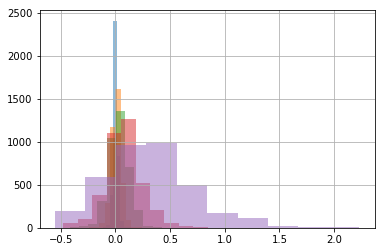

In [131]:
# close metrics
for x in pct_chg_keys: pct_chg_df_dict[x][symbol].hist(alpha=0.5)

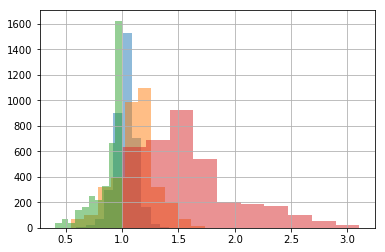

In [132]:
# price to moving averages
for df in (pct_50d_ma_df, pct_200d_ma_df, pct_52wh_df, pct_52wl_df): 
    df[symbol].hist(alpha=0.5)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


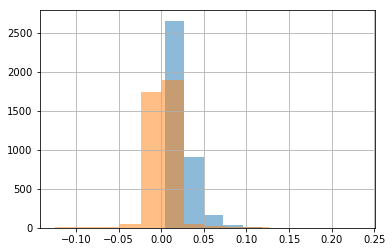

In [51]:
# intra day and open gaps
for df in (intra_day_chg_df, open_gap_df): 
    print(df[symbol].hist(alpha=0.5))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


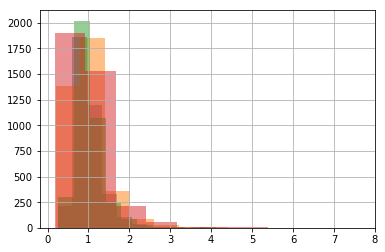

In [55]:
# volume and dollar value
for df in (pct_vol_10da_df, pct_vol_50da_df, pct_dv_10da_df, pct_dv_50da_df): 
    print(df[symbol].hist(alpha=0.5))

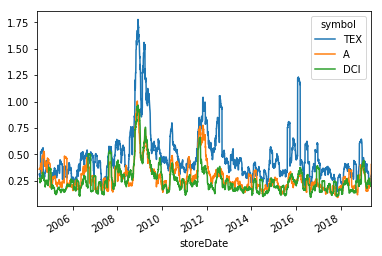

In [56]:
# realized volatility on sample set
roll_realvol_df[sample_symbols].plot();

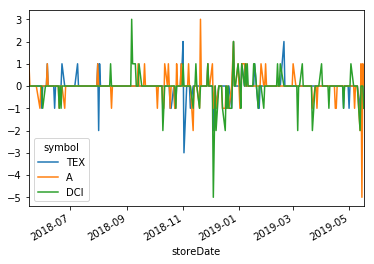

In [57]:
# statistically significant moves
pct_stds_df[sample_symbols].tail(252).plot()

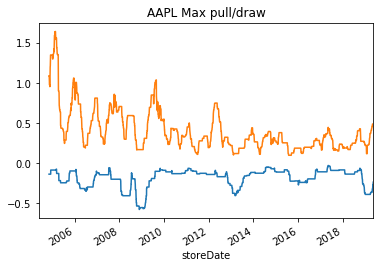

In [58]:
max_draw_df[symbol].plot()
max_pull_df[symbol].plot(title=f'{symbol} Max pull/draw')

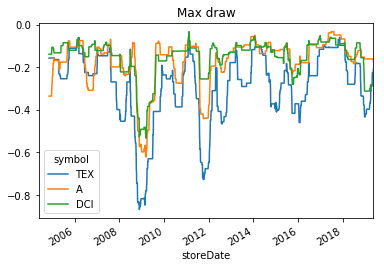

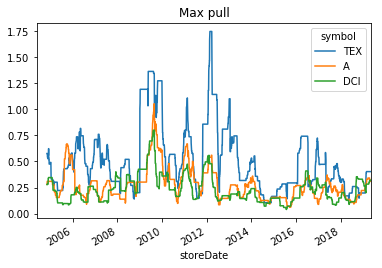

In [59]:
# historical max draws / pulls
max_draw_df[sample_symbols].plot(title='Max draw')
max_pull_df[sample_symbols].plot(title='Max pull')

In [255]:
# Company transforms
from utils.pricing import eq_wgt_indices, to_index_form, shorten_name

def get_df(ticker, desc, desc_df, period, tgt_df):
    if ticker in desc_df.index: return tgt_df[period][shorten_name(desc_df.loc[ticker, desc])]
    else: return np.nan

In [308]:
%%time
sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')

Sectors: 11, Industries: 136
CPU times: user 2.73 ms, sys: 506 µs, total: 3.24 ms
Wall time: 2.78 ms


In [415]:
%%time
bench_index = to_index_form(close_df[bench], bench)
pct_chg_bench_dict = {x: bench_index.pct_change(x) for x in pct_chg_keys[1:]}
bench_pct_stds_df = pct_chg_bench_dict[50].apply(
    lambda x: sign_compare(x, x.std())) # number of std devs for 50 day % moves

bench_delta_dict = {
    k: pct_chg_df_dict[k][tickers].subtract(pct_chg_bench_dict[k].values, axis=1)
    for k in pct_chg_keys[1:]}
print('Benchmark complete')

Benchmark complete
CPU times: user 58.1 ms, sys: 151 ms, total: 209 ms
Wall time: 57.2 ms


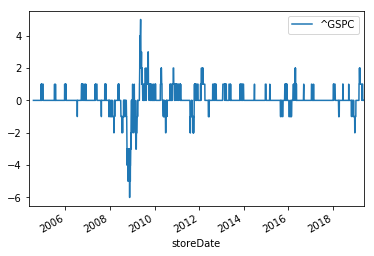

In [416]:
bench_pct_stds_df.plot();

In [417]:
%%time
sect_index = eq_wgt_indices(profile, close_df[tickers], 'sector', sectors, subset=tickers)
pct_chg_sect_dict = {x: sect_index.pct_change(x) for x in pct_chg_keys[1:]}
sect_pct_stds_df = pct_chg_sect_dict[50].apply(
    lambda x: sign_compare(x, x.std())) # number of std devs for 50 day % moves

sect_delta_dict = {
    k: pct_chg_df_dict[k][tickers].apply(
        lambda x: x - get_df(x.name, 'sector', profile, k, pct_chg_sect_dict)) 
    for k in pct_chg_keys[1:]}
print('Sector complete')

Sector complete
CPU times: user 1.81 s, sys: 51.4 ms, total: 1.86 s
Wall time: 1.83 s


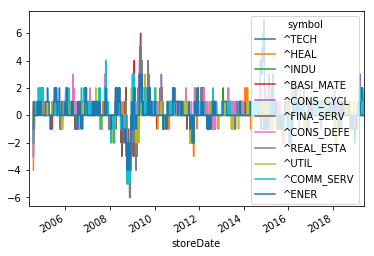

In [418]:
sect_pct_stds_df.plot();

In [419]:
%%time
ind_index = eq_wgt_indices(profile, close_df[tickers], 'industry', industries, subset=tickers)
pct_chg_ind_dict = {x: ind_index.pct_change(x) for x in pct_chg_keys[1:]}
ind_pct_stds_df = pct_chg_ind_dict[50].apply(
    lambda x: sign_compare(x, x.std())) # number of std devs for 50 day % moves

ind_delta_dict = {
    k: pct_chg_df_dict[k][tickers].apply(
        lambda x: x - get_df(x.name, 'industry', profile, k, pct_chg_ind_dict)) 
    for k in pct_chg_keys[1:]}
print('Industry complete')

Industry complete
CPU times: user 2.92 s, sys: 167 ms, total: 3.09 s
Wall time: 3.01 s


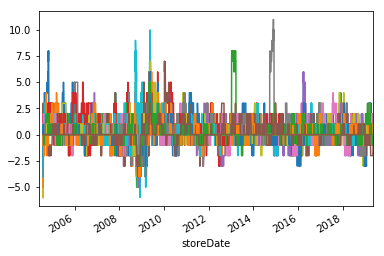

In [420]:
ind_pct_stds_df.plot(legend=False);

In [421]:
# how many other players in the same industry
profile.loc[profile.industry.isin([profile.loc['AMZN', 'industry']]), ['longBusinessSummary']]

,longBusinessSummary
symbol,
AAP,"Advance Auto Parts, Inc. provides automotive r..."
AMZN,"Amazon.com, Inc. engages in the retail sale of..."
AZO,"AutoZone, Inc. retails and distributes automot..."
BABA,"Alibaba Group Holding Limited, through its sub..."
BBY,"Best Buy Co., Inc. operates as a retailer of t..."
DKS,"Dick's Sporting Goods, Inc. operates as a spor..."
EBAY,eBay Inc. operates commerce platforms connecti...
ETSY,"Etsy, Inc. operates Etsy.com, an online market..."
FIVE,"Five Below, Inc. operates as a specialty value..."


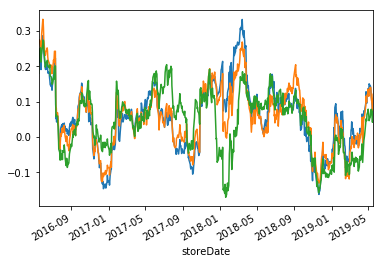

In [422]:
# relative performance to bench, sector, industry
period = 50; days = 252*3
for df in (bench_delta_dict, sect_delta_dict, ind_delta_dict):
    df[period]['AMZN'].tail(days).plot()

In [446]:
%%time
# stiching deltas and stds
super_list = []
for t in tickers:
    symbol_list = []
    for k in bench_delta_dict.keys():
        delta_names = [str(x)+'Delta'+str(k) for x in ['bench', 'sector', 'industry']]
        df = pd.concat([bench_delta_dict[k][t], sect_delta_dict[k][t], ind_delta_dict[k][t]], axis=1)
        df.columns = delta_names
        symbol_list.append(df)
    bench_stds = bench_pct_stds_df
    bench_stds.columns = ['benchPctStds']
    symbol_list.append(bench_stds)
    if t in profile.index:
        sect_stds = sect_pct_stds_df[shorten_name(profile.loc[t, 'sector'])]
        sect_stds.name = 'sectPctStds'
        ind_stds = ind_pct_stds_df[shorten_name(profile.loc[t, 'industry'])]
        ind_stds.name = 'indPctStds'
        symbol_list.append(sect_stds)
        symbol_list.append(ind_stds)
    symbol_df = pd.concat(symbol_list, axis=1)
    symbol_df['symbol'] = t
    symbol_df.set_index('symbol', append=True)
    super_list.append(symbol_df)
delta_df = pd.concat(super_list, axis=0, sort=False)
delta_df.shape

CPU times: user 6.79 s, sys: 521 ms, total: 7.31 s
Wall time: 7.31 s


In [451]:
# test
delta_df.loc[delta_df.symbol.isin(['AAPL'])].tail(10)

,benchDelta20,sectorDelta20,industryDelta20,benchDelta50,sectorDelta50,industryDelta50,benchDelta200,sectorDelta200,industryDelta200,benchPctStds,sectPctStds,indPctStds,symbol
storeDate,,,,,,,,,,,,,
2019-05-06,0.044540,-0.014830,0.010894,0.155236,0.055580,0.023544,0.053457,-0.235784,0.005062,0.0,1.0,1.0,AAPL
2019-05-07,0.017840,-0.030909,0.010185,0.132872,0.038282,0.023057,0.028854,-0.267124,0.003336,0.0,0.0,0.0,AAPL
2019-05-08,0.016619,-0.025941,0.010642,0.133275,0.029485,0.023438,0.032169,-0.265821,0.002924,0.0,1.0,0.0,AAPL
2019-05-09,0.006554,-0.012319,0.011445,0.119769,0.041628,0.024182,0.024837,-0.269220,0.001779,0.0,0.0,0.0,AAPL
2019-05-10,-0.006501,-0.025840,0.011565,0.103978,0.030658,0.024016,0.000030,-0.312547,-0.000601,0.0,0.0,0.0,AAPL
2019-05-13,-0.033263,-0.037608,0.009596,0.058522,-0.005144,0.021518,-0.034693,-0.314918,0.001423,0.0,0.0,0.0,AAPL
2019-05-14,-0.028560,-0.033843,0.010490,0.057951,-0.023522,0.022686,-0.027510,-0.312454,0.002567,0.0,0.0,0.0,AAPL
2019-05-15,-0.022509,-0.029967,0.011216,0.065700,-0.015239,0.022687,-0.011716,-0.345745,0.002680,0.0,0.0,0.0,AAPL
2019-05-16,-0.055925,-0.085116,0.008675,0.051319,-0.048831,0.020314,-0.025409,-0.415581,0.000392,0.0,1.0,0.0,AAPL


In [ ]:
def px_mom_co_feats(df, ind_df, groups=('Bench', 'Sector','Industry'), rolls=[20,60,120]):

    ndf = pd.DataFrame()
    c,o,l,h,v = df['close'], df['open'], df['low'], df['high'], df['volume']
    (bech_idx, sect_idx, ind_idx) = groups
    sect_idx, ind_idx = shorten_name(sect_idx), shorten_name(ind_idx)

    for r in rolls:
        ndf['rsBench'+str(r)] = (c.pct_change(r) - ind_df[bech_idx].pct_change(r))
        ndf['rsSect'+str(r)] = (c.pct_change(r) - ind_df[sect_idx].pct_change(r))
        # rsInd meaninful only if len > 10
        ndf['rsInd'+str(r)] = (c.pct_change(r) - ind_df[ind_idx].pct_change(r))

    # vol as a % of 10 and 60 day averages
    ndf['volPctMa10'] = v / v.rolling(10).mean()
    ndf['volPctMa60'] = v / v.rolling(60).mean()

    # of std deviations for benchmark, sector, and industry
    bench_pct_chg = ind_df.loc[c.index, bech_idx].pct_change()
    sect_pct_chg = ind_df.loc[c.index, sect_idx].pct_change()
    ind_pct_chg = ind_df.loc[c.index, ind_idx].pct_change()
    ndf['benchPctChgStds'] = bench_pct_chg.apply(sign_compare, args=(bench_pct_chg.std(),))
    ndf['sectPctChgStds'] = sect_pct_chg.apply(sign_compare, args=(sect_pct_chg.std(),))
    ndf['indPctChgStds'] = ind_pct_chg.apply(sign_compare, args=(ind_pct_chg.std(),))

    ndf['sector'] = groups[1]
    ndf['industry'] = groups[2]

    return ndf

Max draw: -0.08803194437193373, Max pull: 0.10238417993492877


(-0.08803194437193373, 0.10238417993492877)

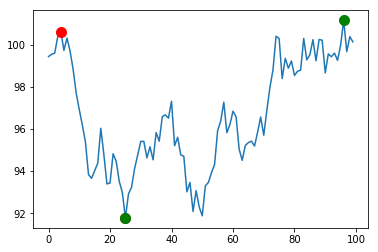

In [67]:
# Graph drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot([l_dd, h_dd], [r_w[l_dd], r_w[h_dd],], 'o', color='Red', markersize=10)
plt.plot([l_p, h_p], [r_w[l_p], r_w[h_p]], 'o', color='Green', markersize=10)

print(f'Max draw: {r_w[l_dd]/r_w[h_dd]-1}, Max pull: {r_w[h_p]/r_w[l_p]-1}')
max_draw(r_w), max_pull(r_w)

#### Visualize sectors and industry groups

In [265]:
tgt_sectors = [
        'Technology',
        'Communication Services',
        'Healthcare',
        'Consumer Cyclical',
        'Consumer Defensive',
        'Industrials'
        ]

size_df = get_focus_tickers(quotes, profile, tgt_sectors)
ind_count = size_df.groupby('industry').count()['marketCap']
tgt_industries = list(ind_count.loc[ind_count > ind_count.median() - 1].index)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


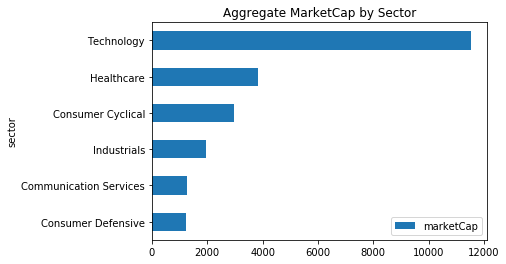

In [266]:
size_df.loc[tickers].groupby(by='sector').sum().sort_values('marketCap')\
    .plot(kind='barh', title='Aggregate MarketCap by Sector')

,sum,count
count,26.00,26.00
mean,874.59,19.54
std,"1,290.83",8.88
min,82.50,11.00
25%,290.61,13.00
50%,486.00,16.50
75%,"1,096.08",23.50
max,"6,613.73",50.00


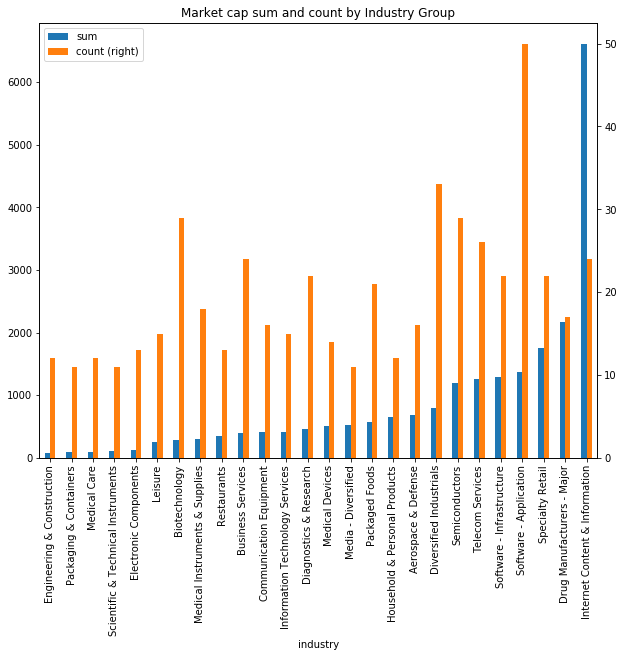

In [267]:
ind_group = size_df.loc[tickers].groupby(by='industry')
sorting_df = ind_group.agg(['sum', 'count'])['marketCap'].sort_values(by='sum')
sorting_df.plot(
    kind='bar', figsize=(10,8), secondary_y='count', 
    title='Market cap sum and count by Industry Group')
sorting_df.describe()

In [271]:
size_df.loc[tickers].groupby(by=['sector', 'industry']).agg(['count', 'sum'])

marketCap         
                                                              count      sum
sector                 industry                                             
Communication Services Telecom Services                          26 1,254.65
Consumer Cyclical      Leisure                                   15   250.52
                       Media - Diversified                       11   518.52
                       Packaging & Containers                    11    92.80
                       Restaurants                               13   348.53
                       Specialty Retail                          22 1,748.01
Consumer Defensive     Household & Personal Products             12   650.84
                       Packaged Foods                            21   568.77
Healthcare             Biotechnology                             29   288.36
                       Diagnostics & Research                    22   459.85
                       Drug Manufacturers - Major                17 2,174.09
                       Medical Care                              12    96.58
                       Medical Devices                           14   512.16
                       Medical Instruments & Supplies            18   297.37
Industrials            Aerospace & Defense                       16   678.76
                       Business Services                         24   392.64
                       Diversified Industrials                   33   796.75
                       Engineering & Construction                12    82.50
Technology             Communication Equipment                   16   414.94
                       Electronic Components                     13   123.75
                       Information Technology Services           15   418.12
                       Internet Content & Information            24 6,613.73
                       Scientific & Technical Instruments        11   108.42
                       Semiconductors                            29 1,195.86
                       Software - Application                    50 1,366.10
                       Software - Infrastructure                 22 1,286.67

#### Understand price changes across universe

In [317]:
sector_mapper = {
    s: list(size_df.loc[
            size_df.index.isin(tickers) 
            & (size_df.sector == 'Technology')].index)
    for s in tgt_sectors}

In [273]:
from utils.pricing import get_ind_index

tail = 90
Y = get_ind_index(px_close.dropna(subset=['^GSPC'])[tickers], tail=tail) - 1

In [274]:
indices_df = pd.concat(
    [eq_wgt_indices(profile, px_close, 'sector', tgt_sectors, subset=tickers, tail=tail),
    eq_wgt_indices(profile, px_close, 'industry', tgt_industries, subset=tickers, tail=tail),
    to_index_form(px_close[bench].tail(tail), bench)], axis=1).drop_duplicates() - 1

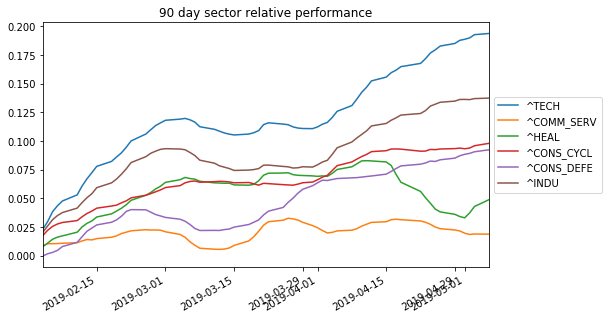

In [275]:
from utils.pricing import shorten_name

loc, margin = 'center left', (1, 0.5)

sect_idx = indices_df[[shorten_name(x) for x in tgt_sectors]].rolling(10).mean().dropna()
ax = sect_idx.plot(figsize=(8,5), title=f'{tail} day sector relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

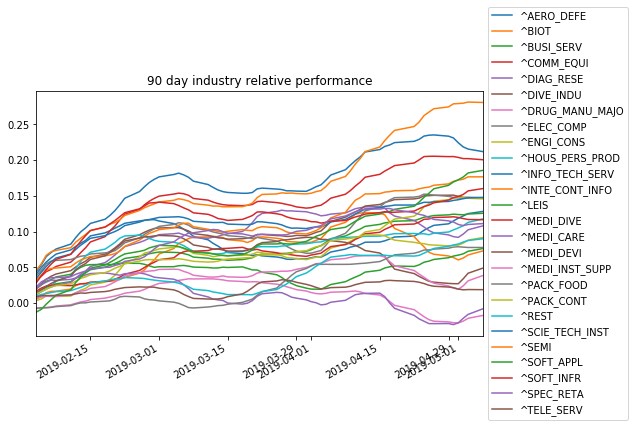

In [318]:
ind_idx = indices_df[
    [shorten_name(x) for x in tgt_industries]]\
    .rolling(10).mean().dropna()
ax = ind_idx.plot(figsize=(8,5), title=f'{tail} day industry relative performance')
ax.legend(loc=loc, bbox_to_anchor=margin)

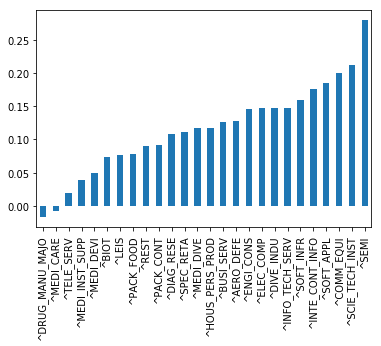

In [307]:
ind_idx.iloc[-1].sort_values().plot(kind='bar')

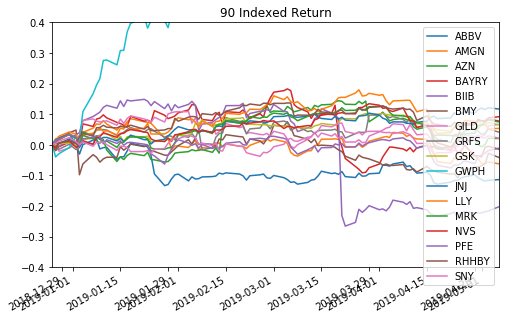

In [320]:
see_industry = 'Drug Manufacturers - Major'
see_tickers = list(size_df.loc[size_df.index.isin(tickers) & (size_df.industry == see_industry)].index)

Y[see_tickers].plot(
    figsize=(8,5), 
    title=f'{tail} Indexed Return',
    ylim=(-.4, 0.4))
ax.legend(loc=loc, bbox_to_anchor=margin)

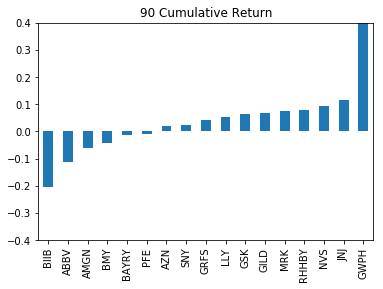

In [321]:
Y[see_tickers].iloc[-1].sort_values().plot(
    kind='bar',
    title=f'{tail} Cumulative Return',
    ylim=(-.4, 0.4))

#### Remove price outliers

In [ ]:
y_outliers = Y.loc[(Y > 1).any(1).values, (Y > 1).any().loc[(Y > 1).any()].index]
y_outliers.max().sort_values()

#### Old training

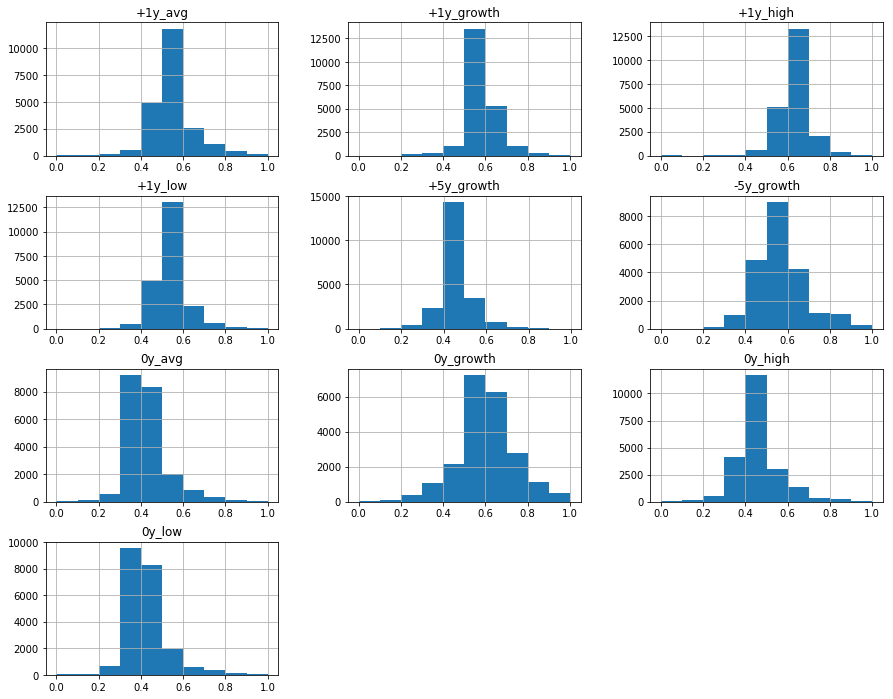

In [20]:
X_train.hist(figsize=(15,12));